In [ ]:
pip install imbalanced-learn

In [ ]:
!pip install nltk

In [ ]:
!pip install xgboost

In [ ]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Importing libraries

In [ ]:
import pandas as pd
import re
import nltk
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import numpy as np

Load dataset

In [ ]:
data=pd.read_csv('sentimentdataset.csv')
data.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [ ]:
data = data.drop(data.columns[:2], axis=1)
data.head()

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Text       732 non-null    object 
 1   Sentiment  732 non-null    object 
 2   Timestamp  732 non-null    object 
 3   User       732 non-null    object 
 4   Platform   732 non-null    object 
 5   Hashtags   732 non-null    object 
 6   Retweets   732 non-null    float64
 7   Likes      732 non-null    float64
 8   Country    732 non-null    object 
 9   Year       732 non-null    int64  
 10  Month      732 non-null    int64  
 11  Day        732 non-null    int64  
 12  Hour       732 non-null    int64  
dtypes: float64(2), int64(4), object(7)
memory usage: 74.5+ KB


In [ ]:
print(data.isnull().values.any())

df=data.copy()

df.columns

False


Index(['Text', 'Sentiment', 'Timestamp', 'User', 'Platform', 'Hashtags',
       'Retweets', 'Likes', 'Country', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')

Data Preprocessing

In [ ]:
def clean_text(text):
    text = str(text)  # Ensure text format
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions (@user)
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text# Remove special characters & numbers

df["Cleaned_Text"] = df["Text"].apply(clean_text)
df['Cleaned_Hashtags'] = df['Hashtags'].apply(clean_text)


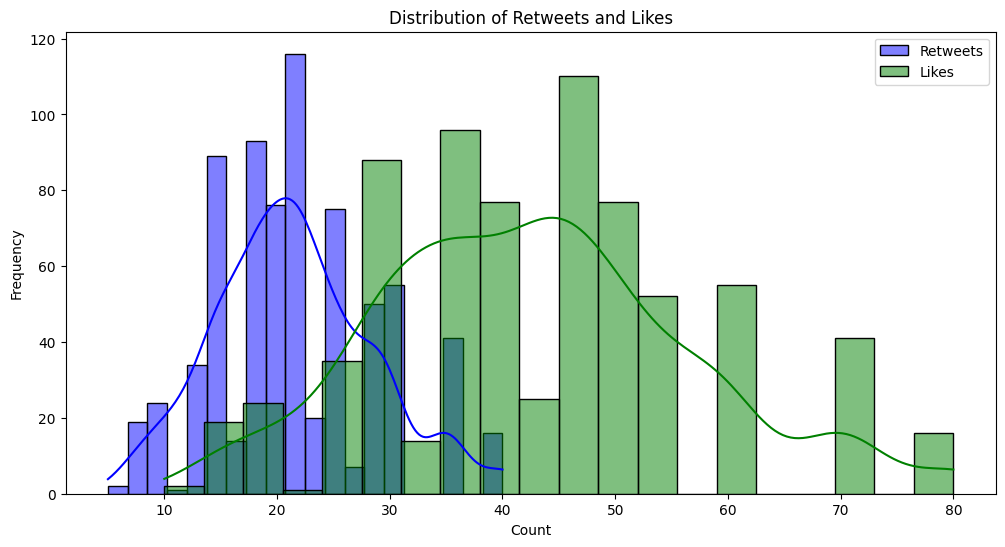

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data['Retweets'], bins=20, kde=True, color='blue', label='Retweets')
sns.histplot(data['Likes'], bins=20, kde=True, color='green', label='Likes')
plt.title('Distribution of Retweets and Likes')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

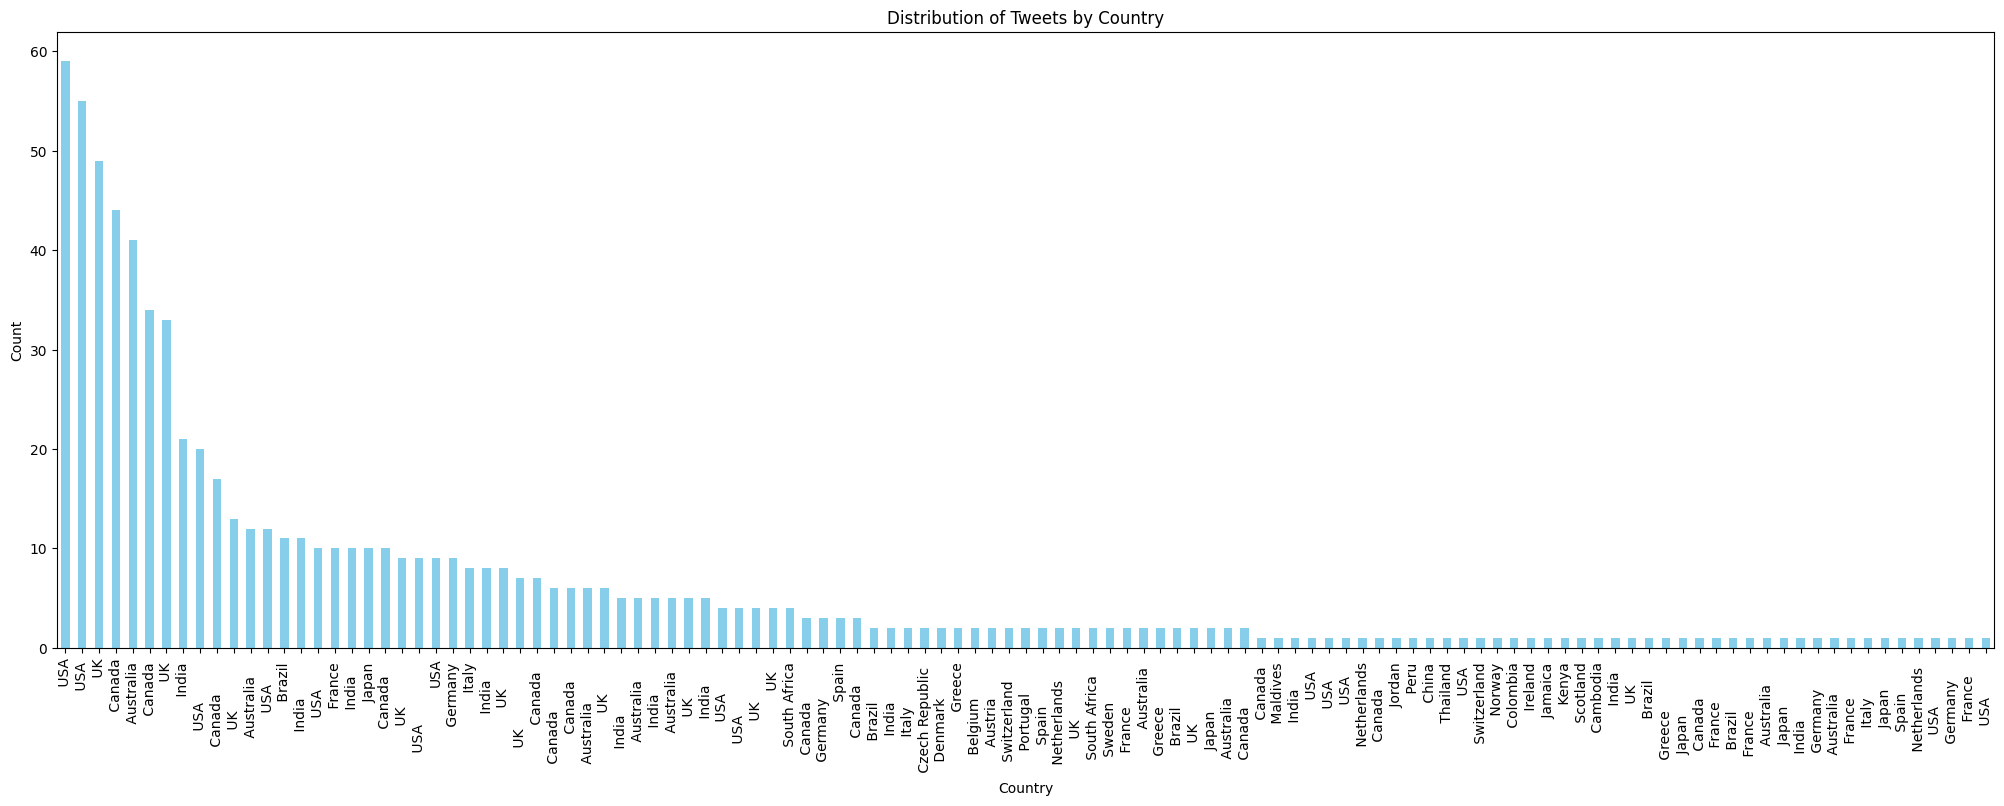

In [ ]:
country_counts = data['Country'].value_counts()

# Plot bar chart for country distribution
plt.figure(figsize=(25, 8))
country_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Tweets by Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()

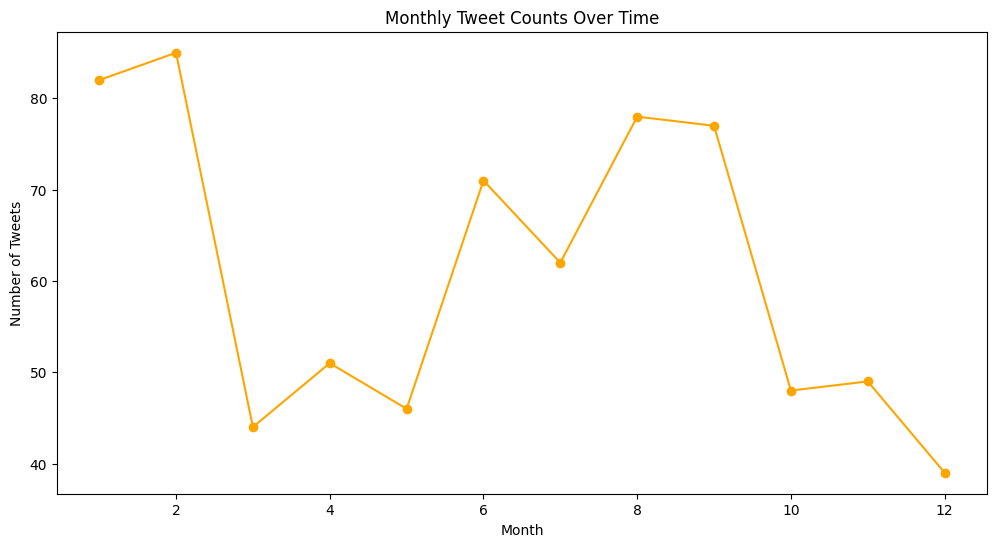

In [ ]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['Month'] = data['Timestamp'].dt.month

# Plot a line chart for tweet counts over time
monthly_tweet_counts = data.groupby('Month').size()
plt.figure(figsize=(12, 6))
monthly_tweet_counts.plot(kind='line', marker='o', color='orange')
plt.title('Monthly Tweet Counts Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Tweets')
plt.show()

In [ ]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

important_stopwords = {'not', 'very', 'always', 'only', 'too', 'more'}

def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenize & lowercase
    tokens = [word for word in tokens if word not in stop_words or word in important_stopwords]  # Keep important stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return " ".join(tokens)


df["Processed_Text"] = df["Cleaned_Text"].apply(preprocess_text)
df["Processed_Hashtags"] = df["Cleaned_Hashtags"].apply(preprocess_text)


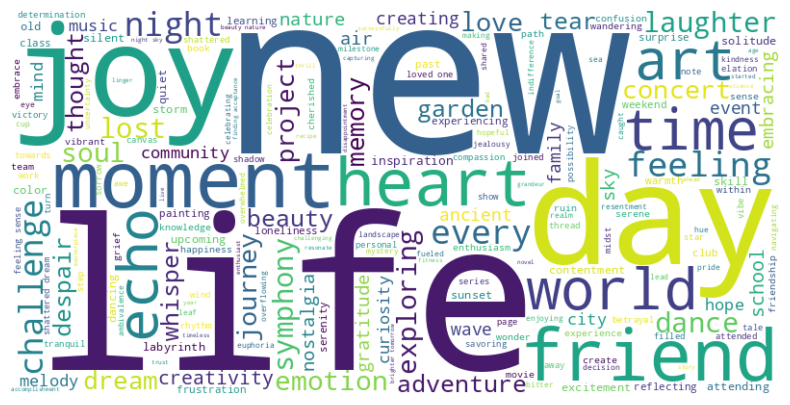

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(df["Processed_Text"]))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


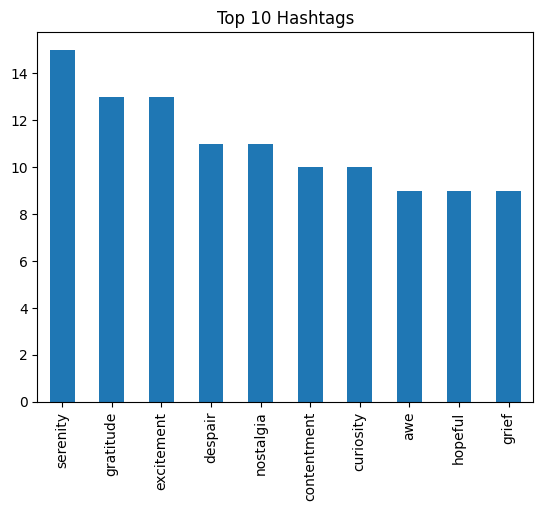

In [ ]:
hashtags = pd.Series(" ".join(df["Processed_Hashtags"]).split())
hashtags.value_counts().head(10).plot(kind='bar', title="Top 10 Hashtags")
plt.show()

Feature engineering and data encoding

In [ ]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"])  # Convert to datetime format
df["Year"] = df["Timestamp"].dt.year
df["Month"] = df["Timestamp"].dt.month
df["Day"] = df["Timestamp"].dt.day
df["Hour"] = df["Timestamp"].dt.hour

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df["Processed_Text"])

tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

print(df['Sentiment'].unique())

[' Positive  ' ' Negative  ' ' Neutral   ' ' Anger        '
 ' Fear         ' ' Sadness      ' ' Disgust      ' ' Happiness    '
 ' Joy          ' ' Love         ' ' Amusement    ' ' Enjoyment    '
 ' Admiration   ' ' Affection    ' ' Awe          ' ' Disappointed '
 ' Surprise     ' ' Acceptance   ' ' Adoration    ' ' Anticipation '
 ' Bitter       ' ' Calmness     ' ' Confusion    ' ' Excitement   '
 ' Kind         ' ' Pride        ' ' Shame        ' ' Confusion '
 ' Excitement ' ' Shame ' ' Elation       ' ' Euphoria      '
 ' Contentment   ' ' Serenity      ' ' Gratitude     ' ' Hope          '
 ' Empowerment   ' ' Compassion    ' ' Tenderness    ' ' Arousal       '
 ' Enthusiasm    ' ' Fulfillment  ' ' Reverence     ' ' Compassion'
 ' Fulfillment   ' ' Reverence ' ' Elation   ' ' Despair         '
 ' Grief           ' ' Loneliness      ' ' Jealousy        '
 ' Resentment      ' ' Frustration     ' ' Boredom         '
 ' Anxiety         ' ' Intimidation    ' ' Helplessness    '
 ' 

In [ ]:
df['Sentiment'] = df['Sentiment'].str.strip().str.lower()

positive_keywords = ['positive', 'joy', 'happy', 'happiness', 'love', 'excitement', 'pride', 'gratitude', 'euphoria', 'admiration', 'enthusiasm', 'satisfaction']
negative_keywords = ['negative', 'anger', 'fear', 'sadness', 'frustration', 'despair', 'anxiety', 'grief', 'loneliness', 'disgust', 'boredom', 'jealousy', 'resentment', 'helplessness']
neutral_keywords = ['neutral', 'confusion', 'indifference', 'calmness', 'acceptance', 'curiosity']

def categorize_sentiment(sentiment):
    for word in positive_keywords:
        if word in sentiment:
            return 'Positive'
    for word in negative_keywords:
        if word in sentiment:
            return 'Negative'
    for word in neutral_keywords:
        if word in sentiment:
            return 'Neutral'
    return 'Neutral'

df['Sentiment_transformed'] = df['Sentiment'].apply(categorize_sentiment)


In [ ]:
print(df['Sentiment_transformed'].value_counts())


print(df['Sentiment_transformed'].unique())

Sentiment_transformed
Neutral     463
Positive    202
Negative     67
Name: count, dtype: int64
['Positive' 'Negative' 'Neutral']


In [ ]:
df['Engagement'] = df['Likes'] + df['Retweets']

df_encoded = pd.get_dummies(df, columns=["Country"], drop_first=True)

label_encoder = LabelEncoder()

df["Sentiment_transformed"] = label_encoder.fit_transform(df["Sentiment_transformed"])

print(f"Encoded target labels: {df['Sentiment_transformed'].unique()}")
df["Platform_encoded"] = label_encoder.fit_transform(df["Platform"])

final_df = pd.concat([df_encoded.drop(columns=["Text", "Cleaned_Text", "Processed_Text", "Hashtags", "Cleaned_Hashtags", "Processed_Hashtags", "Timestamp"]),
                       tfidf_df,
                       df[["Processed_Hashtags","Engagement","Sentiment_transformed","Platform_encoded"]]], axis=1)

pd.set_option('display.max_columns', None)
final_df

Encoded target labels: [2 0 1]


Sentiment                                   User     Platform  Retweets  \
0    positive                          User123          Twitter        15.0   
1    negative                          CommuterX        Twitter         5.0   
2    positive                          FitnessFan      Instagram       20.0   
3    positive                          AdventureX       Facebook        8.0   
4     neutral                          ChefCook        Instagram       12.0   
..        ...                                    ...          ...       ...   
727     happy       ScienceProjectSuccessHighSchool     Facebook       20.0   
728     happy            BirthdayPartyJoyHighSchool    Instagram       25.0   
729     happy   CharityFundraisingTriumphHighSchool      Twitter       22.0   
730     happy    MulticulturalFestivalJoyHighSchool     Facebook       21.0   
731     happy    VirtualTalentShowSuccessHighSchool    Instagram       24.0   

     Likes  Year  Month  Day  Hour  Sentiment_transformed  Engagement  \
0     30.0  2023      1   15    12               Positive        45.0   
1     10.0  2023      1   15     8               Negative        15.0   
2     40.0  2023      1   15    15               Positive        60.0   
3     15.0  2023      1   15    18               Positive        23.0   
4     25.0  2023      1   15    19                Neutral        37.0   
..     ...   ...    ...  ...   ...                    ...         ...   
727   39.0  2017      8   18    18               Positive        59.0   
728   48.0  2018      6   22    14               Positive        73.0   
729   42.0  2019      4    5    17               Positive        64.0   
730   43.0  2020      2   29    20               Positive        64.0   
731   47.0  2020     11   15    15               Positive        71.0   

     Country_ Australia    Country_ Australia     Country_ Australia      \
0                   False                  False                   False   
1                   False                  False                   False   
2                   False                  False                   False   
3                   False                  False                   False   
4                   False                  False                   False   
..                    ...                    ...                     ...   
727                 False                  False                   False   
728                 False                  False                   False   
729                 False                  False                   False   
730                 False                  False                   False   
731                 False                  False                   False   

     Country_ Australia       Country_ Australia        \
0                      False                     False   
1                      False                     False   
2                      False                     False   
3                      False                     False   
4                      False                     False   
..                       ...                       ...   
727                    False                     False   
728                    False                     False   
729                    False                     False   
730                    False                     False   
731                    False                     False   

     Country_ Australia          Country_ Australia           \
0                         False                        False   
1                         False                        False   
2                         False                        False   
3                         False                        False   
4                         False                        False   
..                          ...                          ...   
727                       False                        False   
728                       False                        F

In [ ]:
vectorizer_hashtags = CountVectorizer(max_features=5000, ngram_range=(1, 3))
X_count_hashtags = vectorizer_hashtags.fit_transform(df["Processed_Hashtags"])

count_df_hashtags = pd.DataFrame(X_count_hashtags.toarray(), columns=vectorizer_hashtags.get_feature_names_out())

print(count_df_hashtags.head())

final_df = pd.concat([final_df, count_df_hashtags], axis=1)

final_df = final_df.loc[:, ~final_df.columns.duplicated()]

non_numeric_cols = final_df.select_dtypes(include=['object']).columns
print(non_numeric_cols)

final_df = final_df.drop(columns=["Sentiment", "User", "Platform","Processed_Hashtags"])

final_df = final_df.loc[:, ~final_df.columns.duplicated()]

   abstractart  abyssofheartache  academicfrustration  \
0            0                 0                    0   
1            0                 0                    0   
2            0                 0                    0   
3            0                 0                    0   
4            0                 0                    0   

   academicfrustration highschoolstress  acceptance  \
0                                     0           0   
1                                     0           0   
2                                     0           0   
3                                     0           0   
4                                     0           0   

   acceptance beautifulchaos  acceptance challenge  acceptance diversity  \
0                          0                     0                     0   
1                          0                     0                     0   
2                          0                     0                     0   
3                     

In [ ]:
label_encoder = LabelEncoder()
final_df["Sentiment_transformed"] = label_encoder.fit_transform(df["Sentiment_transformed"])

from sklearn.model_selection import train_test_split

X = final_df.drop(columns=["Sentiment_transformed"])
y = final_df["Sentiment_transformed"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Handling class imbalance with SMOTE

Sentiment_transformed
1    463
2    202
0     67
Name: count, dtype: int64
Imbalance Ratio: 6.91


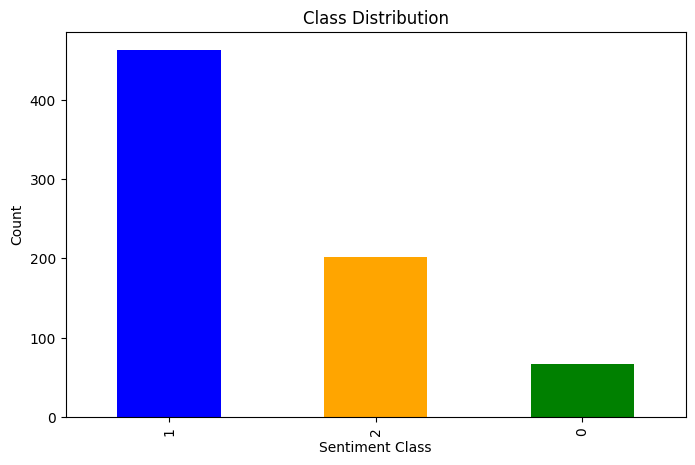

In [ ]:
class_distribution = df["Sentiment_transformed"].value_counts()
print(class_distribution)

# Calculate imbalance rate
imbalance_ratio = class_distribution.max() / class_distribution.min()
print(f"Imbalance Ratio: {imbalance_ratio:.2f}")
# Plot class distribution
plt.figure(figsize=(8,5))
class_distribution.plot(kind="bar", color=["blue", "orange", "green"])
plt.title("Class Distribution")
plt.xlabel("Sentiment Class")
plt.ylabel("Count")
plt.show()

In [ ]:
# Given class distribution
class_counts = [463, 202, 67]

# Compute imbalance ratio
imbalance_ratio = max(class_counts) / min(class_counts)
print(f"Imbalance Ratio: {imbalance_ratio:.2f}")

Imbalance Ratio: 6.91


Model training and evaluation

In [ ]:
print("Class Distribution in Training Data Before SMOTE:")
print(y_train.value_counts())

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Class Distribution After SMOTE:")
print(y_train_resampled.value_counts())

# Train XGBoost model on resampled data
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    random_state=42,
    eval_metric='mlogloss'
)

xgb_model.fit(X_train_resampled, y_train_resampled)

y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Class Distribution in Training Data Before SMOTE:
Sentiment_transformed
1    370
2    161
0     54
Name: count, dtype: int64
Class Distribution After SMOTE:
Sentiment_transformed
0    370
1    370
2    370
Name: count, dtype: int64
Accuracy: 82.31%
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        13
           1       0.84      0.89      0.86        93
           2       0.76      0.63      0.69        41

    accuracy                           0.82       147
   macro avg       0.82      0.82      0.82       147
weighted avg       0.82      0.82      0.82       147

Confusion Matrix:
[[12  1  0]
 [ 2 83  8]
 [ 0 15 26]]


Hyperparameter tunning

In [ ]:
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.3]
}

xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)

grid_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, cv=3, scoring='accuracy', n_iter=10, verbose=2)
grid_search.fit(X_train_resampled, y_train_resampled)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Evaluate the performance of the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Best Model Accuracy: {accuracy_best * 100:.2f}%")
print("Classification Report of Best Model:")
print(classification_report(y_test, y_pred_best))
print("Confusion Matrix of Best Model:")
print(confusion_matrix(y_test, y_pred_best))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=300; total time=   9.1s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=300; total time=   8.8s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=300; total time=   9.2s
[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=300; total time=  10.4s
[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=300; total time=  11.9s
[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=300; total time=  10.6s
[CV] END gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=200; total time=   7.8s
[CV] END gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=200; total time=  18.9s
[CV] END gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=200; total time=  11.2s
[CV] END gamma=0.3, learning_rate=0.1, max_depth=3, n_estimators=200; total time=  20.2s
[CV] END gamma=0.3, learning_rate=0.1, max_dep